# **Spark NLP - News Headline Categorization**
## 1. Loading our Spark Environment and Data

In [3]:
# Install Pyspark & Setup our Java Environment - Takes less than a minute

#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://downloads.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop3.2.tgz
#!tar -xvf /content/spark-3.1.3-bin-hadoop3.2.tgz
#!pip install -q findspark

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
from pyspark.ml import Pipeline 
from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import col, udf,regexp_replace,isnull
from pyspark.sql.types import StringType,IntegerType
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [5]:
# Download and unzip our zipfile
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/uci-news-aggregator.zip'
zipresp = urlopen(zipurl) # Create a new file on the hard drive
tempzip = open("/tmp/tempfile.zip", "wb") # Write the contents of the downloaded file into the new file
tempzip.write(zipresp.read()) # Close the newly-created file
tempzip.close() # Re-open the newly-created file with ZipFile()
zf = ZipFile("/tmp/tempfile.zip") # Extract its contents into <extraction_path>
zf.extractall(path = '') # note that extractall will automatically create the path, left blank so it's in working directory
# close the ZipFile instance
zf.close()

In [6]:
spark = SparkSession.builder.master("local[*]").appName("Spark NLP News Data").getOrCreate()

In [7]:
# Obtain our data

news_data = spark.read.csv("uci-news-aggregator.csv", header = 'True',inferSchema='True')

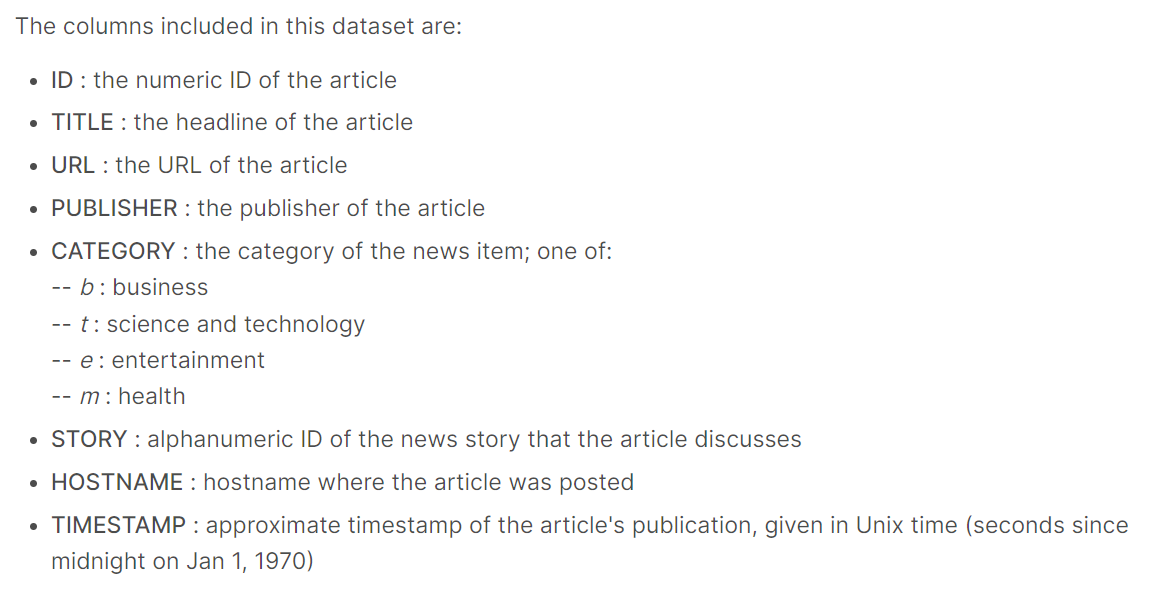

In [8]:
news_data.show()

+---+--------------------+--------------------+--------------------+--------+--------------------+--------------------+-------------+
| ID|               TITLE|                 URL|           PUBLISHER|CATEGORY|               STORY|            HOSTNAME|    TIMESTAMP|
+---+--------------------+--------------------+--------------------+--------+--------------------+--------------------+-------------+
|  1|Fed official says...|http://www.latime...|   Los Angeles Times|       b|ddUyU0VZz0BRneMio...|     www.latimes.com|1394470370698|
|  2|Fed's Charles Plo...|http://www.livemi...|            Livemint|       b|ddUyU0VZz0BRneMio...|    www.livemint.com|1394470371207|
|  3|US open: Stocks f...|http://www.ifamag...|        IFA Magazine|       b|ddUyU0VZz0BRneMio...| www.ifamagazine.com|1394470371550|
|  4|Fed risks falling...|http://www.ifamag...|        IFA Magazine|       b|ddUyU0VZz0BRneMio...| www.ifamagazine.com|1394470371793|
|  5|Fed's Plosser: Na...|http://www.moneyn...|           Mone

In [9]:
news_data.count()

422937

In [10]:
title_category = news_data.select("TITLE","CATEGORY")

In [11]:
title_category.show()

+--------------------+--------+
|               TITLE|CATEGORY|
+--------------------+--------+
|Fed official says...|       b|
|Fed's Charles Plo...|       b|
|US open: Stocks f...|       b|
|Fed risks falling...|       b|
|Fed's Plosser: Na...|       b|
|Plosser: Fed May ...|       b|
|Fed's Plosser: Ta...|       b|
|Fed's Plosser exp...|       b|
|US jobs growth la...|       b|
|ECB unlikely to e...|       b|
|ECB unlikely to e...|       b|
|EU's half-baked b...|       b|
|Europe reaches cr...|       b|
|ECB FOCUS-Stronge...|       b|
|EU aims for deal ...|       b|
|Forex - Pound dro...|       b|
|Noyer Says Strong...|       b|
|EU Week Ahead Mar...|       b|
|ECB member Noyer ...|       b|
|Euro Anxieties Wa...|       b|
+--------------------+--------+
only showing top 20 rows



Let's check null values in TITLE and CATEGORY columns

In [12]:
def null_value_count(df):
  null_columns_counts = []
  numRows = df.count()
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

In [13]:
null_columns_count_list = null_value_count(title_category)

In [14]:
spark.createDataFrame(null_columns_count_list, ['Column_With_Null_Value', 'Null_Values_Count']).show()

+----------------------+-----------------+
|Column_With_Null_Value|Null_Values_Count|
+----------------------+-----------------+
|                 TITLE|              389|
|              CATEGORY|              516|
+----------------------+-----------------+




There are 389 empty titles and 516 categories

Let's drop/delete the null values

In [15]:
title_category = title_category.dropna()

In [16]:
title_category.count()

422421

In [19]:
title_category.show(truncate=False)

+---------------------------------------------------------------------------+--------+
|TITLE                                                                      |CATEGORY|
+---------------------------------------------------------------------------+--------+
|Fed official says weak data caused by weather, should not slow taper       |b       |
|Fed's Charles Plosser sees high bar for change in pace of tapering         |b       |
|US open: Stocks fall after Fed official hints at accelerated tapering      |b       |
|Fed risks falling 'behind the curve', Charles Plosser says                 |b       |
|Fed's Plosser: Nasty Weather Has Curbed Job Growth                         |b       |
|Plosser: Fed May Have to Accelerate Tapering Pace                          |b       |
|Fed's Plosser: Taper pace may be too slow                                  |b       |
|Fed's Plosser expects US unemployment to fall to 6.2% by the end of 2014   |b       |
|US jobs growth last month hit by weather:F

In [20]:
title_category.select("Category").distinct().count()

265

In [21]:
title_category.groupBy("Category").count().orderBy(col("count").desc()).show(truncate=False)

+--------------------+------+
|Category            |count |
+--------------------+------+
|e                   |152127|
|b                   |115935|
|t                   |108237|
|m                   |45616 |
|Us Magazine         |31    |
|Contactmusic.com    |20    |
|GossipCop           |20    |
|Complex.com         |12    |
|CBS News            |12    |
|The Hollywood Gossip|11    |
|HipHopDX            |11    |
|We Got This Covered |10    |
|HeadlinePlanet.com  |10    |
|Gamepur             |8     |
|Consequence of Sound|7     |
|Wetpaint            |7     |
|WorstPreviews.com   |7     |
|TooFab.com          |7     |
|The Escapist        |6     |
|Reality TV World    |5     |
+--------------------+------+
only showing top 20 rows



#Top 20 news title

In [22]:
title_category.groupBy("TITLE").count().orderBy(col("count").desc()).show(truncate=False)

+----------------------------------------------------------------------------------+-----+
|TITLE                                                                             |count|
+----------------------------------------------------------------------------------+-----+
|The article requested cannot be found! Please refresh your browser or go back  ...|145  |
|Business Highlights                                                               |59   |
|Posted by Parvez Jabri                                                            |59   |
|Posted by Imaduddin                                                               |53   |
|Posted by Shoaib-ur-Rehman Siddiqui                                               |52   |
|(click the phrases to see a list)                                                 |51   |
|Business Wire                                                                     |41   |
|PR Newswire                                                                       |38   |

# **2. Data Cleaning**
1. Removing numbers from titles

In [23]:
title_category = title_category.withColumn("only_str",regexp_replace(col('TITLE'), '\d+', ''))

In [24]:
title_category.select("TITLE","only_str").show(truncate=False)

+---------------------------------------------------------------------------+---------------------------------------------------------------------------+
|TITLE                                                                      |only_str                                                                   |
+---------------------------------------------------------------------------+---------------------------------------------------------------------------+
|Fed official says weak data caused by weather, should not slow taper       |Fed official says weak data caused by weather, should not slow taper       |
|Fed's Charles Plosser sees high bar for change in pace of tapering         |Fed's Charles Plosser sees high bar for change in pace of tapering         |
|US open: Stocks fall after Fed official hints at accelerated tapering      |US open: Stocks fall after Fed official hints at accelerated tapering      |
|Fed risks falling 'behind the curve', Charles Plosser says                 

#Split text into words

In [25]:
regex_tokenizer = RegexTokenizer(inputCol="only_str", outputCol="words", pattern="\\W")
raw_words = regex_tokenizer.transform(title_category)

In [26]:
raw_words.show()

+--------------------+--------+--------------------+--------------------+
|               TITLE|CATEGORY|            only_str|               words|
+--------------------+--------+--------------------+--------------------+
|Fed official says...|       b|Fed official says...|[fed, official, s...|
|Fed's Charles Plo...|       b|Fed's Charles Plo...|[fed, s, charles,...|
|US open: Stocks f...|       b|US open: Stocks f...|[us, open, stocks...|
|Fed risks falling...|       b|Fed risks falling...|[fed, risks, fall...|
|Fed's Plosser: Na...|       b|Fed's Plosser: Na...|[fed, s, plosser,...|
|Plosser: Fed May ...|       b|Plosser: Fed May ...|[plosser, fed, ma...|
|Fed's Plosser: Ta...|       b|Fed's Plosser: Ta...|[fed, s, plosser,...|
|Fed's Plosser exp...|       b|Fed's Plosser exp...|[fed, s, plosser,...|
|US jobs growth la...|       b|US jobs growth la...|[us, jobs, growth...|
|ECB unlikely to e...|       b|ECB unlikely to e...|[ecb, unlikely, t...|
|ECB unlikely to e...|       b|ECB unl


#Remove stop words

In [27]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
words_df = remover.transform(raw_words)

In [28]:
words_df.select("words","filtered").show(truncate=False)

+-------------------------------------------------------------------------------------+-------------------------------------------------------------------------------+
|words                                                                                |filtered                                                                       |
+-------------------------------------------------------------------------------------+-------------------------------------------------------------------------------+
|[fed, official, says, weak, data, caused, by, weather, should, not, slow, taper]     |[fed, official, says, weak, data, caused, weather, slow, taper]                |
|[fed, s, charles, plosser, sees, high, bar, for, change, in, pace, of, tapering]     |[fed, charles, plosser, sees, high, bar, change, pace, tapering]               |
|[us, open, stocks, fall, after, fed, official, hints, at, accelerated, tapering]     |[us, open, stocks, fall, fed, official, hints, accelerated, tapering]    

#Now lets encode column of category to a column of category indices

In [29]:
indexer = StringIndexer(inputCol="CATEGORY", outputCol="categoryIndex")
feature_data = indexer.fit(words_df).transform(words_df)

In [30]:
feature_data.select("CATEGORY","categoryIndex").show()

+--------+-------------+
|CATEGORY|categoryIndex|
+--------+-------------+
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
+--------+-------------+
only showing top 20 rows



#Convert text into vectors of token counts

In [31]:
cv = CountVectorizer(inputCol="filtered", outputCol="features")
model = cv.fit(feature_data)
countVectorizer_feateures = model.transform(feature_data)

Create our Training & Test datasets

In [32]:
(trainingData, testData) = countVectorizer_feateures.randomSplit([0.8, 0.2],seed = 11)

## Train our Model and Evaluate it's performance

In [33]:
nb = NaiveBayes(modelType="multinomial",labelCol="categoryIndex", featuresCol="features")
nbModel = nb.fit(trainingData)
nb_predictions = nbModel.transform(testData)

In [34]:
nb_predictions.select("prediction", "categoryIndex", "features").show(5)

+----------+-------------+--------------------+
|prediction|categoryIndex|            features|
+----------+-------------+--------------------+
|       0.0|          0.0|(49043,[21,50,111...|
|       0.0|          0.0|(49043,[20,21,22,...|
|       0.0|          0.0|(49043,[31,504,77...|
|       0.0|          0.0|(49043,[184,226,9...|
|       0.0|          0.0|(49043,[345,511,7...|
+----------+-------------+--------------------+
only showing top 5 rows



In [35]:
evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)
print("Accuracy of NaiveBayes is = %g"% (nb_accuracy))
print("Test Error of NaiveBayes = %g " % (1.0 - nb_accuracy))

Accuracy of NaiveBayes is = 0.925795
Test Error of NaiveBayes = 0.0742047 
